In [1]:
!pip install --upgrade gym==0.25.2

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np
from collections import deque

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
class DQN(nn.Module):
  def __init__(self, state_size, action_size, hidden_size):
    super(DQN, self).__init__()
    self.dense_layer1 = nn.Linear(state_size, hidden_size)
    self.dense_layer2 = nn.Linear(hidden_size, hidden_size)
    self.dense_layer3 = nn.Linear(hidden_size, hidden_size)
    self.dense_layer4 = nn.Linear(hidden_size, hidden_size)
    self.dense_layer5 = nn.Linear(hidden_size, action_size)

  def forward(self, X):
    X = F.relu(self.dense_layer1(X))
    X = F.relu(self.dense_layer2(X))
    X = F.relu(self.dense_layer3(X))
    X = F.relu(self.dense_layer4(X))
    X = self.dense_layer5(X)
    return X

In [39]:
class DQNAgent:
  def __init__(self, state_size, action_size, hidden_size, lr, discount, max_experiences=15000, min_experiences=100, batch_size=32):
    self.action_size = action_size
    self.dqn = DQN(state_size, action_size, hidden_size).to(device)
    self.target_network = DQN(state_size, action_size, hidden_size).to(device)
    self.target_network.load_state_dict(self.dqn.state_dict())
    self.dqn_optimizer = torch.optim.RMSprop(self.dqn.parameters(), lr=lr)
    self.discount = discount
    self.replay_buffer = deque()
    self.max_experiences = max_experiences
    self.min_experiences = min_experiences
    self.batch_size = batch_size

  def select_action(self, state, epsilon):
    with torch.no_grad():
      prob = np.random.random()
      if prob < 1 - epsilon:
        return np.random.choice(np.arange(self.action_size))
      else:
        input_state = torch.FloatTensor(state).to(device)
        action = self.dqn(input_state).max(0)[1].view(-1)
        action = int(action)
        return action

  def add_experience(self, state, action, reward, next_state, done):
    if len(self.replay_buffer) >= self.max_experiences:
      self.replay_buffer.popleft()
    self.replay_buffer.append((state, action, reward, next_state, done))

  def train(self):
    if len(self.replay_buffer) < self.min_experiences:
      return

    # randomly select batch
    samples = np.random.randint(0, len(self.replay_buffer), size=self.batch_size)
    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []

    for sample in samples:
        state, action, reward, next_state, done = self.replay_buffer[sample]
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        next_states.append(next_state)
        dones.append(done)

    state_batch = torch.FloatTensor(np.array(states)).to(device)
    next_state_batch = torch.FloatTensor(np.array(next_states)).to(device)
    action_batch = torch.LongTensor(np.array(actions).reshape(-1, 1)).to(device)
    reward_batch = torch.FloatTensor(np.array(rewards).reshape(-1, 1)).to(device)
    done_batch = torch.FloatTensor(1 - np.array(dones).reshape(-1, 1)).to(device)

    train_q = self.dqn(state_batch)
    train_q = train_q.gather(1, action_batch)

    with torch.no_grad():
      target_batch = reward_batch + done_batch * self.discount * torch.max(self.dqn(next_state_batch).detach(), dim=1)[0].view(self.batch_size, -1)

    dqn_loss = nn.MSELoss()
    dqn_loss_val = dqn_loss(train_q, target_batch)
    self.dqn_optimizer.zero_grad()
    dqn_loss_val.backward()
    self.dqn_optimizer.step()

    return dqn_loss_val.detach().cpu().numpy()

  def update_target_network(self, num_iters, update_every):
    if num_iters % update_every == 0:
      self.target_network.load_state_dict(self.dqn.state_dict())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
env = gym.make('CartPole-v1')
ACTION_SIZE = env.action_space.n
STATE_SIZE = env.observation_space.shape[0]

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [41]:
# set seed
SEED = 31
env.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [42]:
# config
NUM_EPISODE = 1000 # run agent for this many episodes
MIN_EPISODES = 100 # collect data for this many timesteps before training
HIDDEN_SIZE = 64 # number of units in NN hidden layers
LR = 0.00005 # learning rate for optimizer
UPDATE_TARGET_NET_ITER = 1000 # update target network after this many steps
BATCH_SIZE = 64 # mini batch size we train network on
DISCOUNT_RATE = 0.9 # gamma value

EPSILON_START = 1.0 # epsilon start value
EPSILON_MIN = 0.01  # epsilon end value
EPSILON_DECAY_STEPS = NUM_EPISODE * .15 # decay epsilon over this many episodes
EPSILON_STEPS = (EPSILON_START - EPSILON_MIN)/(EPSILON_DECAY_STEPS) # decrement epsilon by this amount every timeste

In [43]:
dqn_agent = DQNAgent(STATE_SIZE, ACTION_SIZE, HIDDEN_SIZE, LR, DISCOUNT_RATE)

In [44]:
stats_rewards_list = []
stats_every = 10
total_reward = 0
timesteps = 0
episode_length = 0
epsilon = EPSILON_START

for episode in range(NUM_EPISODE):
  state = env.reset()
  stats_loss = 0

  # stopping condition for training if agent reaches the amount of reward
  if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 500:
      print("Stopping at episode {} with average rewards of {} in last {} episodes".
          format(episode, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
      break

  while True:
    timesteps += 1
    action = dqn_agent.select_action(state, epsilon)
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    episode_length += 1


    if done:
      next_state = np.zeros(state.shape)
      reward = -1
      dqn_agent.add_experience(state, action, reward, next_state, done)

      stats_rewards_list.append((episode, total_reward, episode_length))
      total_reward = 0
      episode_length = 0

      epsilon -= EPSILON_STEPS
      epsilon = max(epsilon, EPSILON_MIN)
      if timesteps > MIN_EPISODES and episode % stats_every == 0:
        print('Episode: {}'.format(episode),
              'Timestep: {}'.format(timesteps),
              'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
              'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
              'Epsilon: {:.2f}'.format(epsilon))

      break

    else:
      stats_rewards_list.append((episode, total_reward, episode_length))

    state = next_state
    if timesteps > MIN_EPISODES:
      stats_loss = dqn_agent.train()
      dqn_agent.update_target_network(timesteps, UPDATE_TARGET_NET_ITER)

Episode: 10 Timestep: 104 Total reward: 5.5 Episode length: 5.5 Epsilon: 0.93
Episode: 20 Timestep: 211 Total reward: 6.5 Episode length: 6.5 Epsilon: 0.86
Episode: 30 Timestep: 310 Total reward: 5.3 Episode length: 5.3 Epsilon: 0.80
Episode: 40 Timestep: 412 Total reward: 5.7 Episode length: 5.7 Epsilon: 0.73
Episode: 50 Timestep: 523 Total reward: 7.5 Episode length: 7.5 Epsilon: 0.66
Episode: 60 Timestep: 650 Total reward: 6.5 Episode length: 6.5 Epsilon: 0.60
Episode: 70 Timestep: 786 Total reward: 5.8 Episode length: 5.8 Epsilon: 0.53
Episode: 80 Timestep: 923 Total reward: 8.5 Episode length: 8.5 Epsilon: 0.47
Episode: 90 Timestep: 1059 Total reward: 17.5 Episode length: 17.5 Epsilon: 0.40
Episode: 100 Timestep: 1223 Total reward: 8.5 Episode length: 8.5 Epsilon: 0.33
Episode: 110 Timestep: 1400 Total reward: 10.5 Episode length: 10.5 Epsilon: 0.27
Episode: 120 Timestep: 1570 Total reward: 5.5 Episode length: 5.5 Epsilon: 0.20
Episode: 130 Timestep: 1820 Total reward: 11.5 Episod

Text(0, 0.5, 'Episode Reward')

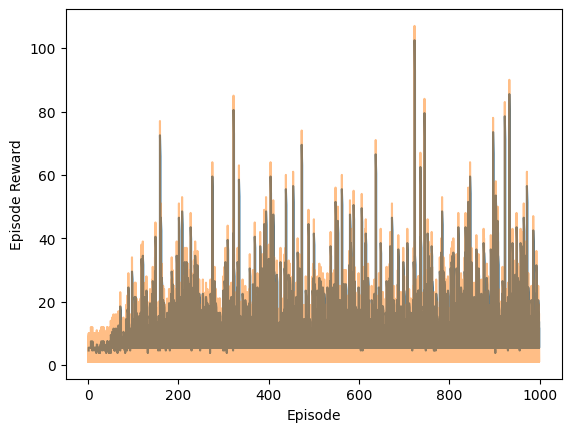

In [59]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0))
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

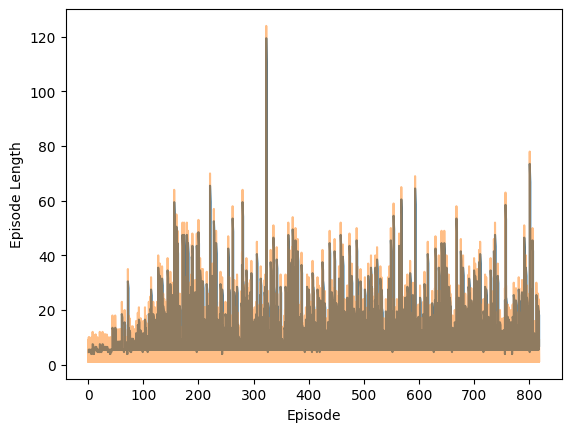

In [52]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')